# Assignment 1: From Dirty Data to Predictive Models

### Imports

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_curve, auc, precision_recall_curve, classification_report
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

np.random.seed(42)

# For Importing Data
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
# Import Data

# fetch dataset (UCI repository ID = 45)
heart = fetch_ucirepo(id=45)

# features (X) and target (y)
X = heart.data.features
y = heart.data.targets

print(heart.metadata)
print(heart.variables)
print(X.head())
print(y.head())

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

### 1. Data Cleaning

#### a. Handling missing values

In [3]:
# First determine what columns have missing values and how many
missing_values = X.isnull().sum()
print(missing_values)

# Only the ca (number of major vessels (0-3) colored by flourosopy, int) and thal (categorical) columns have missing values and it is a relatively low number, so lets take a look at them
# Rows with at least one missing value
rows_with_missing = X[X.isnull().any(axis=1)]
print(rows_with_missing)

# Since there are only 6 observations that are missing in the 303 dataset (less than 2%) I am going to drop the rows with missing values
# Since the features are categorical, it doesn't really make sense to impute or/and missing flag column.

#1. Drop rows with missing values
X = X.dropna()

# Make sure worked
missing_values = X.isnull().sum()
print(missing_values)

#Ensure y matches the filtered X after dropping rows
y = y.loc[X.index]
# Convert multi-class target (0–4) into binary classification:
# 0 = No Disease, 1 = Any Disease
y = (y > 0).astype(int)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
87    53    0   3       128   216    0        2      115      0      0.0   
166   52    1   3       138   223    0        0      169      0      0.0   
192   43    1   4       132   247    1        2      143      1      0.1   
266   52    1   4       128   204    1        0      156      1      1.0   
287   58    1   2       125   220    0        0      144      0      0.4   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
87       1  0.0   NaN  
166      1  NaN   3.0  
192      2  NaN   7.0  
266      2  0.0   NaN  
287      2  NaN   7.0  
302      1  NaN   3.0  
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalac

#### b. Address Noisy or Inconsistent Values

In [4]:
# Check for duplicates - none
print("Duplicates:", X.duplicated().sum())


Duplicates: 0


### c. Data Visualization

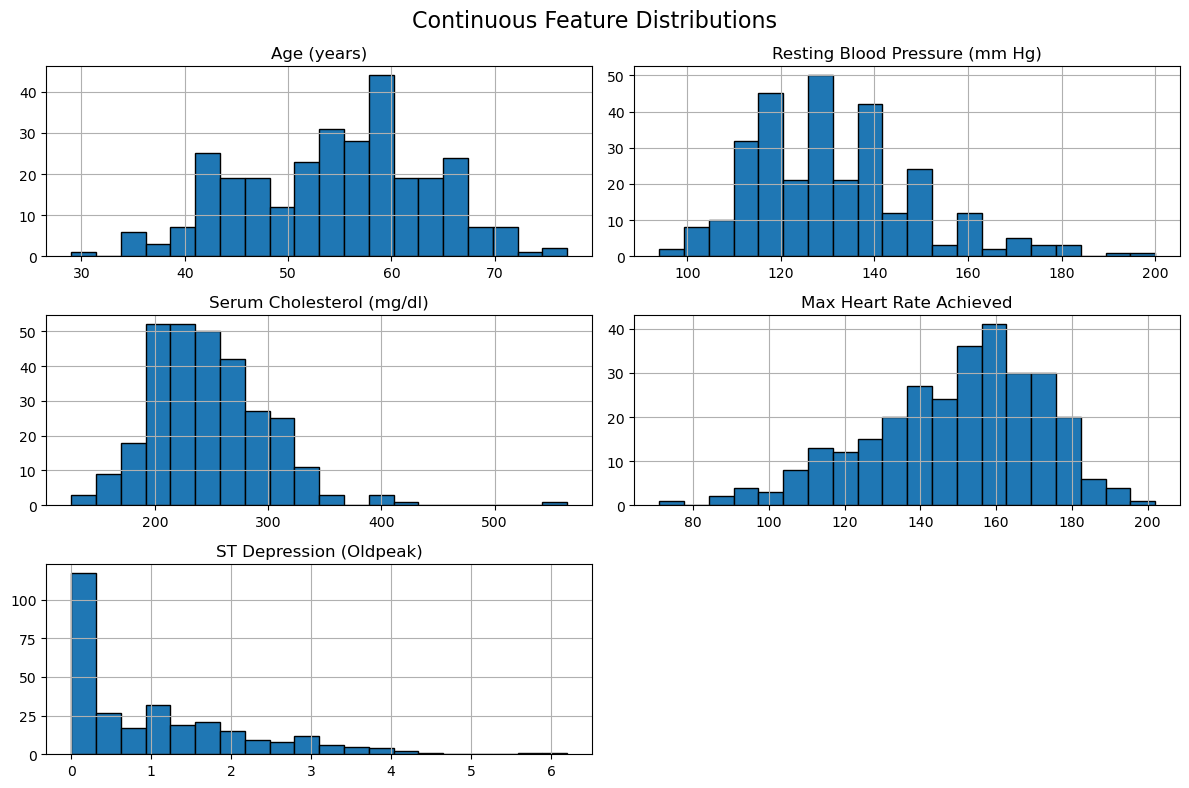

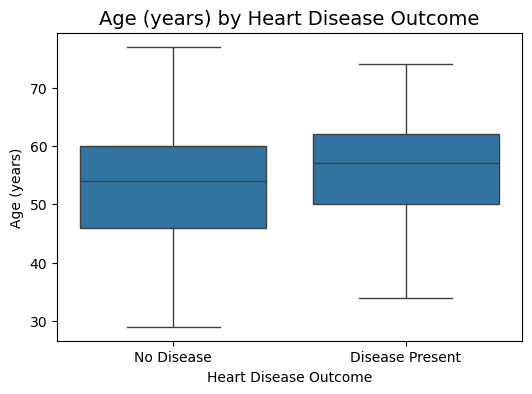

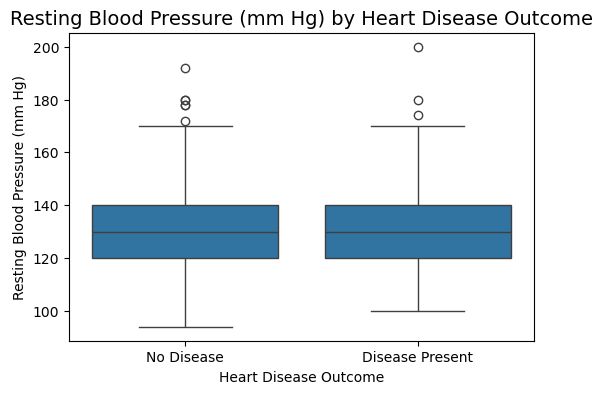

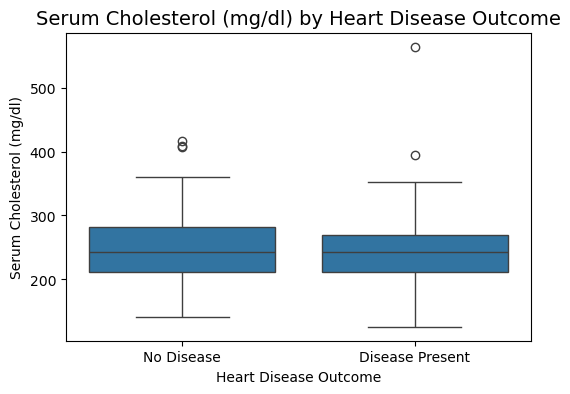

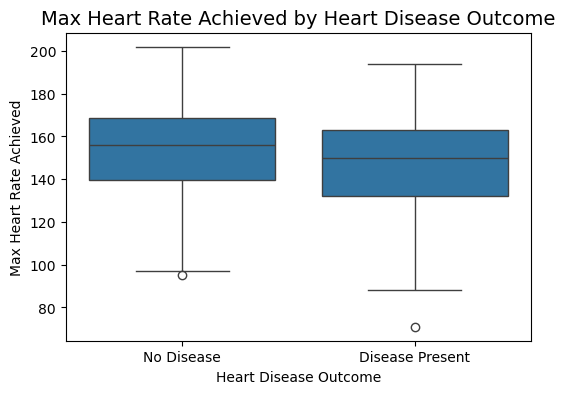

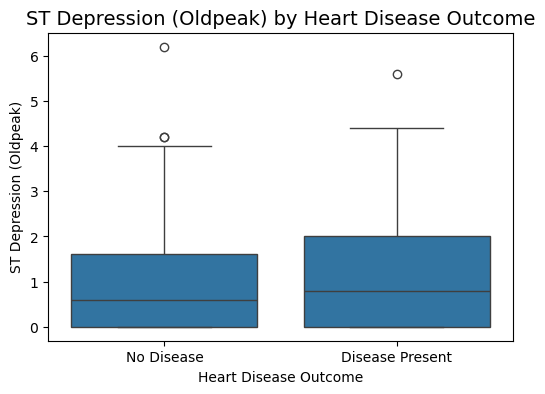

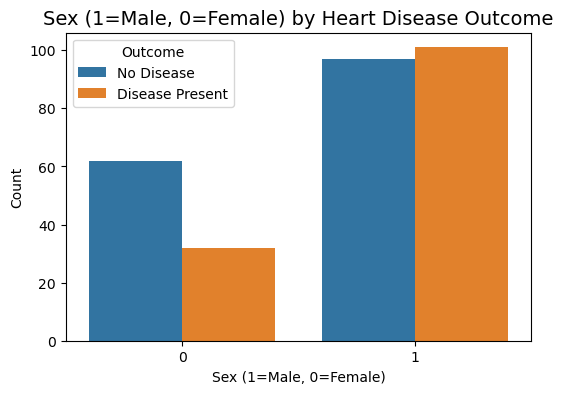

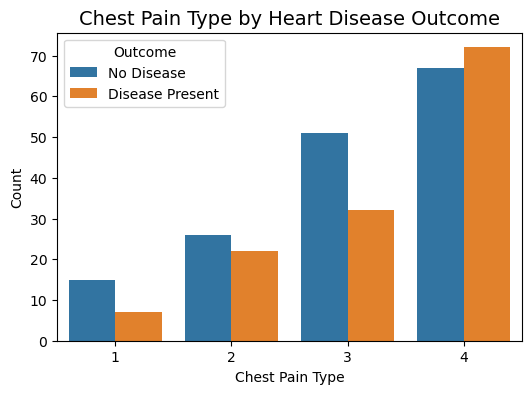

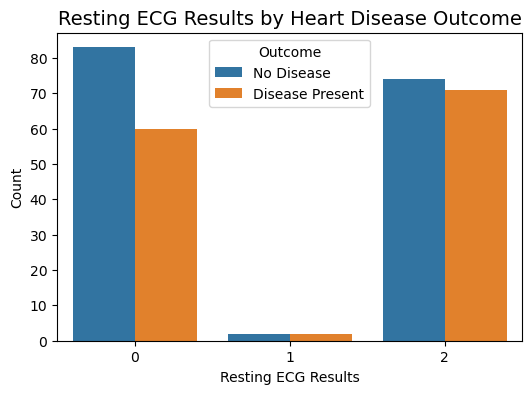

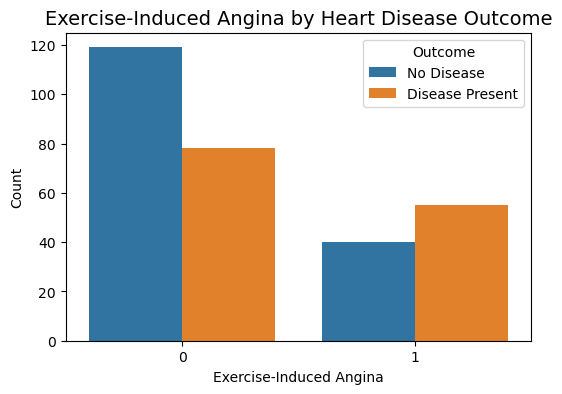

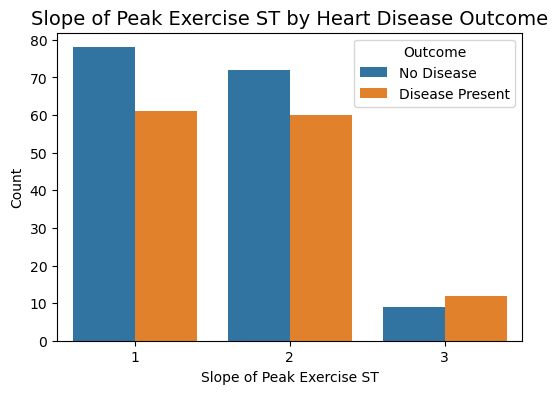

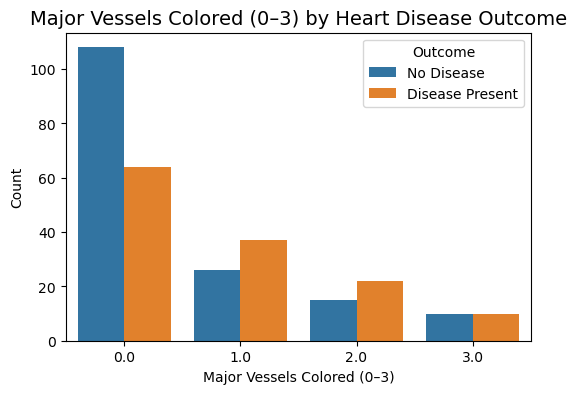

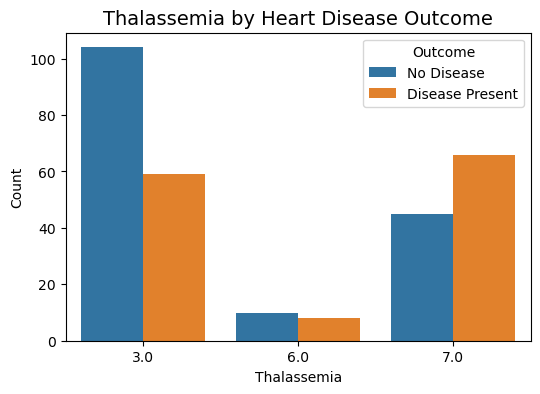

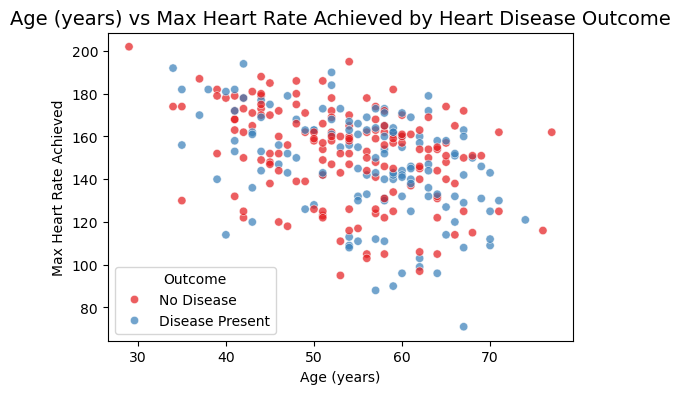

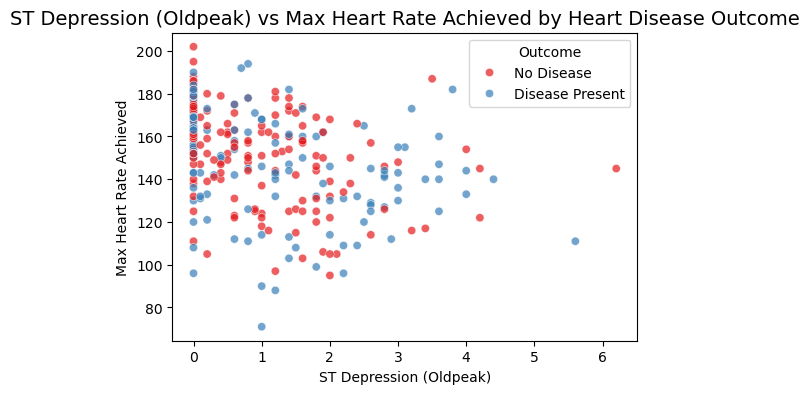

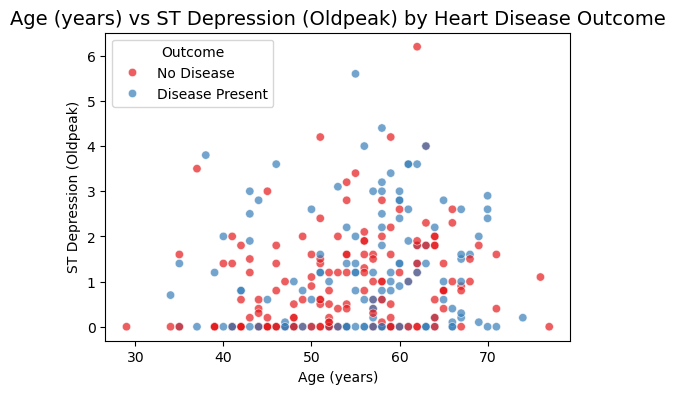

In [5]:
######## Lets visualize the data to see if there are any noisy or incosistent values

# Convert multi-class target (0–4) into binary classification:
# 0 = No Disease, 1 = Any Disease
y = (y > 0).astype(int)

categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
X = X.copy()  # avoid SettingWithCopyWarning
X[categorical_features] = X[categorical_features].astype("category")

# Variable renaming map (for plots only)
var_labels = {
    "age": "Age (years)",
    "trestbps": "Resting Blood Pressure (mm Hg)",
    "chol": "Serum Cholesterol (mg/dl)",
    "thalach": "Max Heart Rate Achieved",
    "oldpeak": "ST Depression (Oldpeak)",
    "sex": "Sex (1=Male, 0=Female)",
    "cp": "Chest Pain Type",
    "fbs": "Fasting Blood Sugar > 120 mg/dl",
    "restecg": "Resting ECG Results",
    "exang": "Exercise-Induced Angina",
    "slope": "Slope of Peak Exercise ST",
    "ca": "Major Vessels Colored (0–3)",
    "thal": "Thalassemia"
}

# Define readable labels for target
target_labels = {0: "No Disease", 1: "Disease Present"}

# Ensure y is flattened to 1D
y_flat = pd.Series(y.values.ravel() if isinstance(y, pd.DataFrame) else y.ravel())

# Add mapped labels to dataframe for plotting
df_plot = X.copy()
df_plot["target"] = y_flat.map(target_labels)


## Histograms of continuous features - good for showing overall distributions, spotting skew/outliers
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
X[continuous_features].rename(columns=var_labels).hist(
    bins=20, figsize=(12, 8), edgecolor="black"
)
plt.suptitle("Continuous Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

## (b) Boxplots of continuous features by target - shows whether features separate well across disease outcome
for col in continuous_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="target", y=col, data=df_plot)
    plt.title(f"{var_labels[col]} by Heart Disease Outcome", fontsize=14)
    plt.xlabel("Heart Disease Outcome")
    plt.ylabel(var_labels[col])
    plt.show()

## Countplots of categorical features by target - visualize class balance + associations with outcome
# skip fbs (too imbalanced)
for col in categorical_features:
    if col == "fbs":
        continue  # skip due to imbalance
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue="target", data=df_plot)
    plt.title(f"{var_labels[col]} by Heart Disease Outcome", fontsize=14)
    plt.xlabel(var_labels[col])
    plt.ylabel("Count")
    plt.legend(title="Outcome", labels=target_labels.values())
    plt.show()

## Scatterplots of key relationships - show correlations or predictive interactions
scatter_pairs = [
    ("age", "thalach"),       # strong negative biological correlation
    ("oldpeak", "thalach"),   # predictive relationship (disease severity)
    ("age", "oldpeak")        # weaker but still interesting relationship
]

for x_feat, y_feat in scatter_pairs:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        x=x_feat,
        y=y_feat,
        hue="target",
        data=df_plot,
        alpha=0.7,
        palette="Set1"   # ensures distinct colors
    )
    plt.title(
        f"{var_labels[x_feat]} vs {var_labels[y_feat]} by Heart Disease Outcome",
        fontsize=14
    )
    plt.xlabel(var_labels[x_feat])
    plt.ylabel(var_labels[y_feat])
    plt.legend(title="Outcome")  # let seaborn handle labels
    plt.show()


#### d. Outliers

In [6]:
######### Outliers

# Observations from plots:
# - trestbps: most values 120–150, a few >180, keep, but consider capping >190
# - chol: most values <350, some extreme >500, likely true but rare
# - oldpeak: highly skewed with tail >5,  not errors, but apply log-transform for modeling - will do later in feature engineering
# - thalach: biologically reasonable; no need to drop values
# - age: no problematic outliers

# Lets count the number of outliers by using the IQR method (define the outliers statistically)
def count_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), len(series), 100*len(outliers)/len(series)

print("\nOutliers before handling:")
for col in ["trestbps", "chol", "thalach", "oldpeak", "age"]:
    n_outliers, n_total, pct = count_outliers_iqr(X[col])
    print(f"{col}: {n_outliers}/{n_total} outliers ({pct:.2f}%)")


# Outliers
X = X.copy()

# Cap trestbps & chol at the IQR upper fence so they are no longer flagged by the IQR rule
for col in ["trestbps", "chol"]:
    Q1 = X[col].quantile(0.25); Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_iqr = Q3 + 1.5*IQR
    # vectorized cap
    X[col] = X[col].clip(upper=upper_iqr)

# Keep thalach and age as-is (very few / no outliers, clinically plausible)
# Keep old peak as well, as the high values are also possible


# Check for outliers
print("\nOutliers after handling:")
for col in ["trestbps", "chol", "thalach", "oldpeak", "age"]:
    n_outliers, n_total, pct = count_outliers_iqr(X[col])
    print(f"{col}: {n_outliers}/{n_total} outliers ({pct:.2f}%)")


Outliers before handling:
trestbps: 9/297 outliers (3.03%)
chol: 5/297 outliers (1.68%)
thalach: 1/297 outliers (0.34%)
oldpeak: 5/297 outliers (1.68%)
age: 0/297 outliers (0.00%)

Outliers after handling:
trestbps: 0/297 outliers (0.00%)
chol: 0/297 outliers (0.00%)
thalach: 1/297 outliers (0.34%)
oldpeak: 5/297 outliers (1.68%)
age: 0/297 outliers (0.00%)


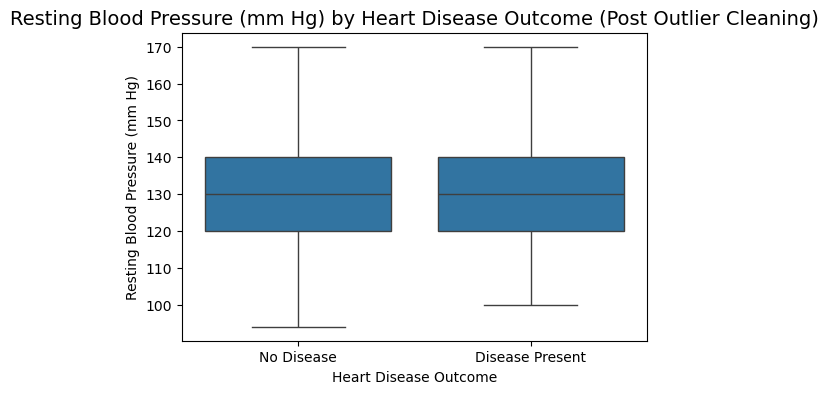

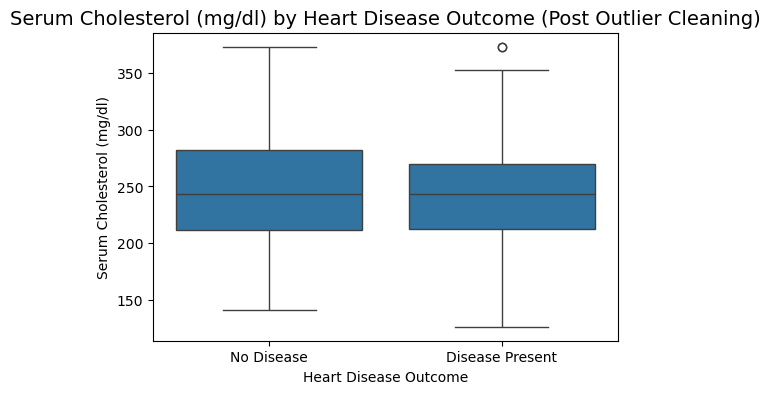

In [7]:
# Visaul Inspection of Values Changed by Outlier Cleaning
# Add mapped labels to dataframe for plotting
df_plot = X.copy()
df_plot["target"] = y_flat.map(target_labels)

for col in ["trestbps", "chol"]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="target", y=col, data=df_plot)
    plt.title(f"{var_labels[col]} by Heart Disease Outcome (Post Outlier Cleaning)", fontsize=14)
    plt.xlabel("Heart Disease Outcome")
    plt.ylabel(var_labels[col])
    plt.show()

### 2. Feature Engineering

Below, I will be:


*  Applying a log transformation to the old peak variable
*  Derive new features
*  Standardize the continous variables
*  OneHot Encode the Categorial Variables




In [8]:

# Create log-transformed oldpeak, oldpeak (exercise-induced ST depression) is highly right-skewed, with most patients near 0 and a few extreme values up to ~6.
# Skewed features can distort models (especially linear ones and Naive Bayes). A log(1+x) transform compresses large values, stabilizes variance, and makes the distribution closer to normal while preserving order.
X = X.copy()
X["oldpeak_log"] = np.log1p(X["oldpeak"])  # log(1+oldpeak) to handle the skew seen in the histograms above

# Define feature groups
continuous_features = ["age", "trestbps", "chol", "thalach", "oldpeak_log"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

# Captures cholesterol risk relative to patient age, which may be more informative than cholesterol or age alone.
X["chol_per_age"] = X["chol"] / X["age"] # Captures abnormal vs normal thal in one clean feature.
X["thal_abn"] = (X["thal"] != 3).astype(int) # in this dataset 3≈normal, 6/7≈abnormal
X["thalach_pct_max"] = X["thalach"] / (220 - X["age"])      # % of age-pred max HR
X["hr_reserve"] = X["thalach"] - (220 - X["age"])           # heart rate reserve


# Column Transformer: scaling + one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features + ["chol_per_age"]),  # standardize continuous - Standardization is more appropriate here because (i) the models we use (Naive Bayes, linear/logistic regression, ridge/lasso) are sensitive to feature scale and often assume Gaussian-like distributions, (ii) continuous variables are measured in different units, and (iii) standardization is more robust to the outliers present in the dataset compared to min-max normalization.
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)  # one-hot categorical
    ]
)


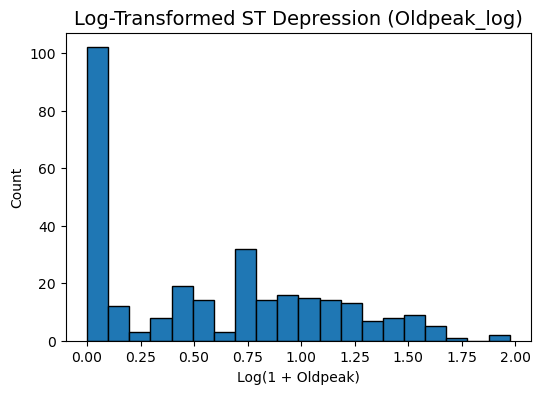

In [9]:
# Histogram of log-transformed Oldpeak
plt.figure(figsize=(6,4))
plt.hist(X["oldpeak_log"], bins=20, edgecolor="black")
plt.title("Log-Transformed ST Depression (Oldpeak_log)", fontsize=14)
plt.xlabel("Log(1 + Oldpeak)")
plt.ylabel("Count")
plt.show()

### 3. Model Training

In [10]:
# flatten y
y = np.ravel(y)

# Split & preprocess data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Dictionary to store models & their predictions
models = {}
predictions = {}
probabilities = {}

#### a. Naives Bayes Classifier - GaussianNB

In [11]:
# Naive Bayes with two alphas (Laplace smoothing)
for alpha in [1.0, 0.01]:
    nb = GaussianNB(var_smoothing=alpha)
    nb.fit(X_train_processed, y_train)
    y_pred = nb.predict(X_test_processed)
    y_prob = nb.predict_proba(X_test_processed)[:,1]

    models[f"GaussianNB (alpha={alpha})"] = nb
    predictions[f"GaussianNB (alpha={alpha})"] = y_pred
    probabilities[f"GaussianNB (alpha={alpha})"] = y_prob

#### b. Linear Regression

In [12]:
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_processed, y_train)
y_prob = lin_reg.predict(X_test_processed)
y_pred = (y_prob >= 0.5).astype(int)

models["Linear Regression"] = lin_reg
predictions["Linear Regression"] = y_pred
probabilities["Linear Regression"] = y_prob

# Ridge Regression
ridge = Ridge(alpha=1.0, max_iter=5000)   # increased max_iter to avoid warnings
ridge.fit(X_train_processed, y_train)
y_prob = ridge.predict(X_test_processed)
y_pred = (y_prob >= 0.5).astype(int)

models["Ridge Regression"] = ridge
predictions["Ridge Regression"] = y_pred
probabilities["Ridge Regression"] = y_prob

# LASSO Regression
lasso = Lasso(alpha=0.01, max_iter=5000)  # increased max_iter to avoid warnings
lasso.fit(X_train_processed, y_train)
y_prob = lasso.predict(X_test_processed)
y_pred = (y_prob >= 0.5).astype(int)

models["LASSO Regression"] = lasso
predictions["LASSO Regression"] = y_pred
probabilities["LASSO Regression"] = y_prob

### 4. Model Evaluation

#### Plots


=== GaussianNB (alpha=1.0) ===
Accuracy: 0.8167
              precision    recall  f1-score   support

  No Disease       0.78      0.91      0.84        32
     Disease       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60



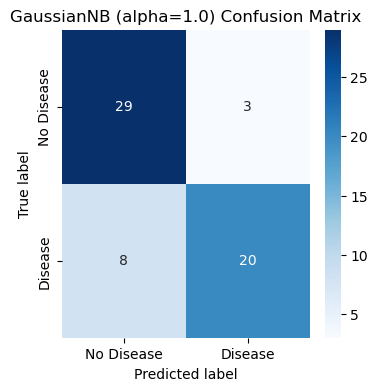

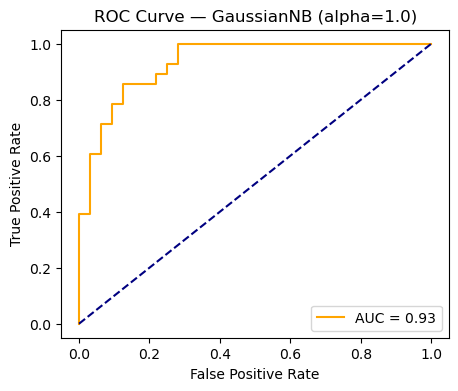


=== GaussianNB (alpha=0.01) ===
Accuracy: 0.8667
              precision    recall  f1-score   support

  No Disease       0.83      0.94      0.88        32
     Disease       0.92      0.79      0.85        28

    accuracy                           0.87        60
   macro avg       0.88      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60



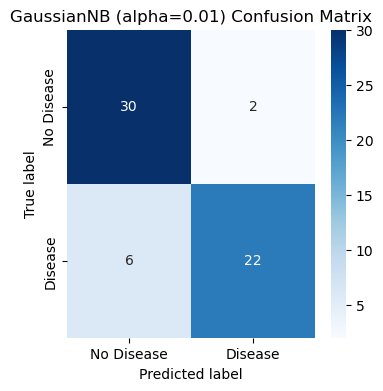

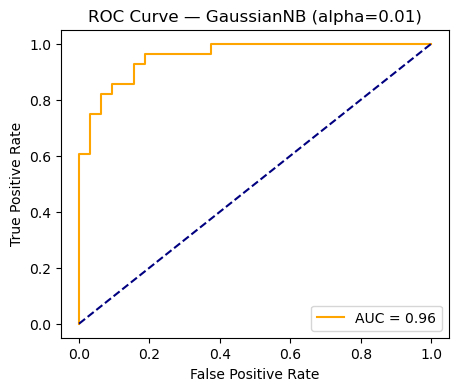


=== Linear Regression ===
Accuracy: 0.8167
              precision    recall  f1-score   support

  No Disease       0.78      0.91      0.84        32
     Disease       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60



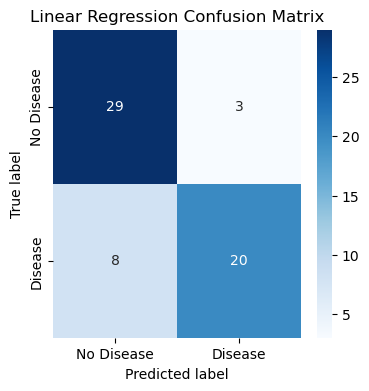

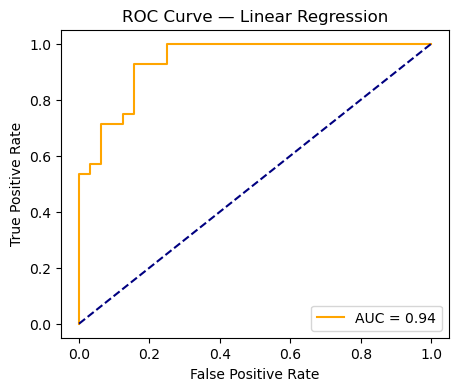


=== Ridge Regression ===
Accuracy: 0.8167
              precision    recall  f1-score   support

  No Disease       0.78      0.91      0.84        32
     Disease       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60



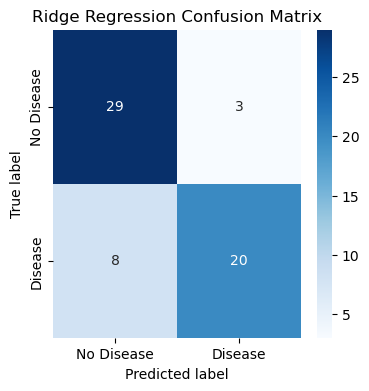

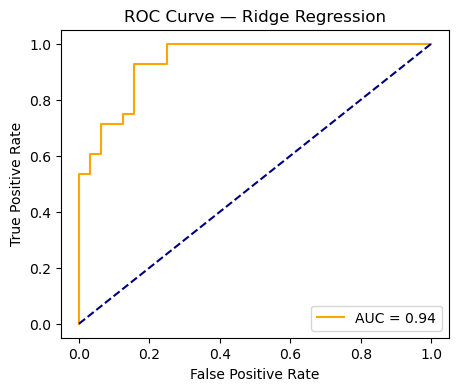


=== LASSO Regression ===
Accuracy: 0.8167
              precision    recall  f1-score   support

  No Disease       0.78      0.91      0.84        32
     Disease       0.87      0.71      0.78        28

    accuracy                           0.82        60
   macro avg       0.83      0.81      0.81        60
weighted avg       0.82      0.82      0.81        60



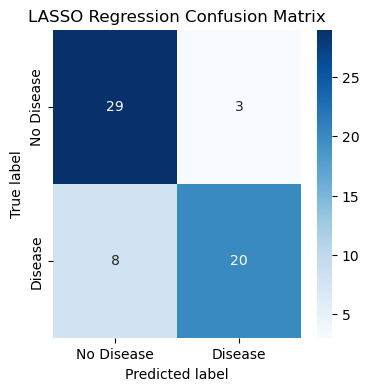

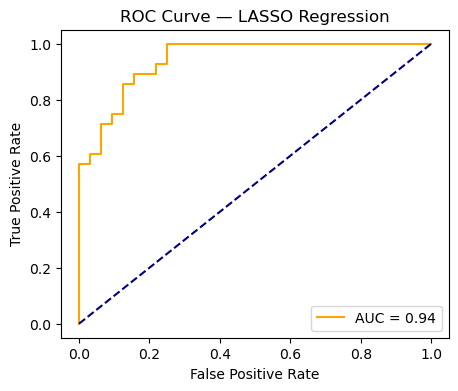

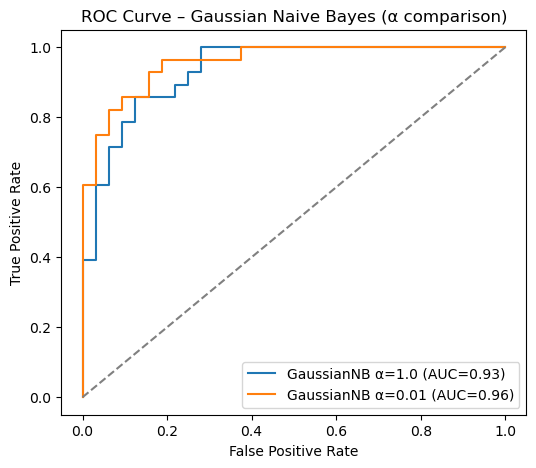

In [13]:
labels = ["No Disease", "Disease"]

# Confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# ROC Curve
def plot_roc(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="orange")
    plt.plot([0,1],[0,1],"--",color="navy")
    plt.title(f"ROC Curve — {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

for name, y_pred in predictions.items():
    print(f"\n=== {name} ===")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print(classification_report(y_test, y_pred, target_names=labels))

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, f"{name} Confusion Matrix")
    plot_roc(y_test, probabilities[name], name)


# Compare GaussianNB models with different alpha (var_smoothing) values
alphas = [1.0, 0.01]
roc_results = {}

for alpha in alphas:
    nb = GaussianNB(var_smoothing=alpha)
    nb.fit(X_train_processed, y_train)
    y_prob = nb.predict_proba(X_test_processed)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    roc_results[alpha] = (fpr, tpr, roc_auc)

# Plot ROC curves for both
plt.figure(figsize=(6, 5))
for alpha, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, label=f"GaussianNB α={alpha} (AUC={roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gaussian Naive Bayes (α comparison)")
plt.legend()
plt.show()

#### Feature Importance

In [14]:
# LASSO shrinks some coefficients exactly to 0 (feature elimination)
lasso_coef_df = pd.DataFrame({
    "feature": preprocessor.get_feature_names_out(),
    "coef": lasso.coef_
})
print("\nTotal features eliminated by LASSO:", (lasso_coef_df["coef"] == 0).sum(),
      "out of", len(lasso_coef_df))

print("\nTop non-zero LASSO coefficients:")
print(lasso_coef_df[lasso_coef_df["coef"] != 0].sort_values(by="coef", ascending=False).head(15))

# Ridge keeps all features but shrinks magnitudes
ridge_coef_df = pd.DataFrame({
    "feature": preprocessor.get_feature_names_out(),
    "coef": ridge.coef_
})
print("\nTop Ridge coefficients (all features kept, but shrunk):")
print(ridge_coef_df.sort_values(by="coef", ascending=False).head(15))


Total features eliminated by LASSO: 15 out of 29

Top non-zero LASSO coefficients:
             feature          coef
11         cat__cp_4  2.265678e-01
28     cat__thal_7.0  1.448278e-01
4   num__oldpeak_log  5.429520e-02
1      num__trestbps  2.893337e-02
2          num__chol  2.624772e-02
18      cat__exang_1  8.280814e-18
3       num__thalach -2.434004e-02
14    cat__restecg_0 -3.035087e-02
10         cat__cp_3 -3.303531e-02
17      cat__exang_0 -4.850542e-02
6         cat__sex_0 -8.288447e-02
26     cat__thal_3.0 -9.063696e-02
19      cat__slope_1 -9.150843e-02
22       cat__ca_0.0 -2.250473e-01

Top Ridge coefficients (all features kept, but shrunk):
             feature      coef
11         cat__cp_4  0.182444
28     cat__thal_7.0  0.142908
24       cat__ca_2.0  0.114679
2          num__chol  0.098692
15    cat__restecg_1  0.091006
23       cat__ca_1.0  0.074476
7         cat__sex_1  0.065540
1      num__trestbps  0.045252
21      cat__slope_3  0.044551
20      cat__slope_2  0.